In [11]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

XSCHEM_RCFILE = "/opt/pdks/sky130A/libs.tech/xschem/xschemrc"
SPICE_DIR = "./spice/"
OUTPUT_DIR = "./output/"
XSCHEM_DIR = "./xschem/"

class test:
    def __init__(self, composed = 0, parametros ={}, lamb = None, target_param = ""):
        self.composed = composed
        self.parametros = parametros
        self.lamd = lamb
        self.target_param = target_param
    def eval(funct):
        return {"eval": funct}
    
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.2                                     # LDO output voltage
Vin = 1.8                                      # LDO supply voltage
Vref = 0.9                                     # LDO voltage reference
IL = 100e-3                                      # Load current
CL = 50e-12                                        # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

# Macromodel

In [12]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.1,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 1}
                              )
stage2_OTA_macro.area_conditions = [10e-3, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_aload"), Symbol("L_aload")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

# Primitives

In [13]:
## PASS TRANSISTOR MACROMODEL

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-1.8, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro/(IL/20e-6)).flatten()}
pt.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

## OTA stage2 transistor MACROMODEL

stage2_t = cs_pmos(netlist='pmos_cm', 
                   type='pmos', 
                   inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vout"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'vgs_lut': (-1.8, -0.1, 0.01), 
                           'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'il': 20e-6,
                           'length': lengths, 
                           '2d_var': ['length', 'vgs']})
stage2_t.build()

stage2_t.parameters = {Symbol('gm_stage2'): np.asarray(stage2_t.gm).flatten(),
                 Symbol('Ro_stage2'): np.asarray(stage2_t.Ro).flatten()}
stage2_t.outputs = {Symbol("W_2stage"): np.asarray(stage2_t.W).flatten(),
                    Symbol("L_2stage"): np.asarray(stage2_t.L).flatten()}

## OTA stage1 differential pair

vs = np.linspace(0.3, 0.8, 20)
vds_diffpar = stage2_OTA_macro.electrical_parameters["Vaouts1"] - vs
vgs_diffpar = stage2_OTA_macro.electrical_parameters["Vpos"] - vs

diffpair_primitive = simplediffpair(netlist='simplediffpair', type='nmos', inputs={'vds_lut': (0.1, 1.2, 0.01), 'vgs_lut': (0.1, 1.8, 0.01), 'vds': vds_diffpar, 'vgs': vgs_diffpar, 'il': 20e-6,
                  'length': lengths, '2d_var': ['vds', 'vgs']})

diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff"): np.asarray(diffpair_primitive.W).flatten(),
                              Symbol("L_diff"): np.asarray(diffpair_primitive.L).flatten()}

## OTA stage1 active load

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'il': 20e-6,
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1
length
vgs
0


# Test

In [14]:
## LDO MACROMODEL

#################### PSRR LDO MACRO #######################
psrr_LDO_macro = test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(-70/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = test()
loadreg_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 0.9,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

## 2stage_OTA MACROMODEL

#################### PSRR 2 stage OTA #######################
psrr_2stage_OTA = test()
psrr_2stage_OTA.name = "psrr_2stage"
psrr_2stage_OTA.tf = ["vout", "V_p"]
psrr_2stage_OTA.netlist = "stage2_OTA"
psrr_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}

psrr_2stage_OTA.opt_goal = "max"
psrr_2stage_OTA.conditions = {"min": [10**(30/20)]}
psrr_2stage_OTA.variables = {}
psrr_2stage_OTA.out_def = {"eval": psrr_2stage_OTA.tf}
 
#################### BW 2 stage OTA #######################
bw_2stage_OTA = test()
bw_2stage_OTA.name = "bw_2stage"
bw_2stage_OTA.tf = ["vout", "V_p"]
bw_2stage_OTA.netlist = "stage2_OTA"
bw_2stage_OTA.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"eval": bw_2stage_OTA.tf}

#################### rout 2 stage OTA #######################
rout_2stage_OTA = test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "stage2_OTA_r"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [4.641589e+02]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

#################### gm 2 stage OTA #######################

gm_2stage_OTA = test()
gm_2stage_OTA.target_param = Symbol("gma")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "V_p"]
gm_2stage_OTA.netlist = "stage2_OTA"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [psrr_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"

gm_2stage_OTA.conditions = {"min": [0.0001]}

## 1stage_OTA MACROMODEL

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_cap"
psrr_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("gaload_2"): Symbol("gaload"),
                   Symbol("Raload_2"): Symbol("Raload_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Cl"): 1e-12}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [40]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.netlist = "ota_cap"
bw_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("gaload_2"): Symbol("gaload"),
                   Symbol("Raload_2"): Symbol("Raload_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"eval": bw_1stage_OTA.tf}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("gaload_2"): Symbol("gaload"),
                   Symbol("Raload_2"): Symbol("Raload_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 0,
                   Symbol("Vr"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rr"): 1000,
                   Symbol("Cl"): 1e-12}
rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1.291550e+03]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

gm_1stage_OTA = test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_cap"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [psrr_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"

gm_1stage_OTA.conditions = {"min": [0.0001]}


# 1 stage

### Build

In [15]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [stage2_OTA_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0

stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]
stage2_OTA_macro.num_level_exp = -1
stage2_OTA_macro.specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
stage2_OTA_macro.opt_specifications = [psrr_2stage_OTA]
stage2_OTA_macro.is_primitive = 0

OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_macro.opt_specifications = [psrr_1stage_OTA]
OTA_macro.is_primitive = 0

ota1_results, ota1_axes, ota1_primouts, ota1_df = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_cap
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
{<sstadex.models.primitives.simplediffpair object at 0x7f7223a82bf0>: {Rdif_1: array([ 219309.44357976,  195461.13923133,  173549.38484815,
        154755.35621208,  139682.72407137,  128352.61689138,
        120176.38835979,  114377.12540327,  110089.96985261,
        106691.23637119,  103719.85904216,  100915.84037349,
         98117.1069927 ,   95183.1855626 ,   92107.84929125,
         88772.29602848,   85111.08546672,   81036.00374497,
         76418.94913439,   71016.10049585,  344709.91724537,
    

In [ ]:
ota1_df["gain"]=20*np.log10(ota1_df["psrr_1stage"])

In [19]:
ota1_df.iloc[5]

Rdif_1         3.046492e+05
gdif_1         3.085187e-04
Cgd           -2.613628e-17
Cgs           -3.762063e-14
Raload_1       8.575230e+05
gaload         1.243104e-04
psrr_1stage    6.902938e+01
rout_1stage    2.277294e+05
gm_1stage      3.031202e-04
W_diff         1.051946e-05
L_diff         8.000000e-07
W_aload        1.079236e-05
L_aload        1.600000e-06
area           2.371182e-05
gain           3.678068e+01
Name: 87, dtype: float64

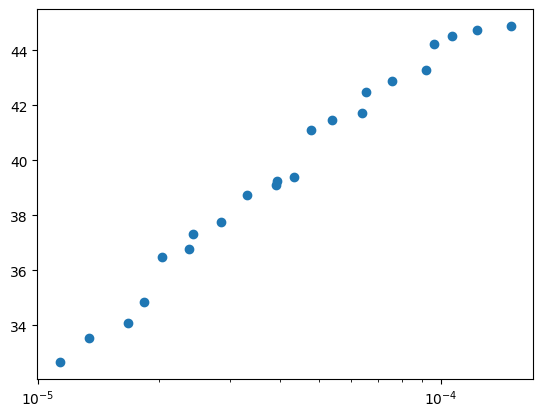

In [21]:
area = ota1_df["area"]
gain = ota1_df["gain"]

plt.scatter(area, gain)
plt.xscale("log")

### Simulate

In [22]:
W_diff_pf = (ota1_df[Symbol("W_diff")].values*1e6)
L_diff_pf = (ota1_df[Symbol("L_diff")].values*1e6)

W_al_pf = (ota1_df[Symbol("W_aload")].values*1e6)
L_al_pf = (ota1_df[Symbol("L_aload")].values*1e6)

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_pf):
    if i>100:
        mult_diff.append(10)
        W_diff_pf[idx] = W_diff_pf[idx]/10
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
        W_al_pf[idx] = W_al_pf[idx]/10
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM4": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
}

simulation_results = spice_sim("ota_tb", values)

[array([ 5.51042263,  7.15566425, 10.51946155,  5.51042263,  7.15566425,
       10.51946155, 10.33459047, 14.45157642, 17.37721742, 23.58095399,
       10.33459047, 14.45157642, 17.37721742, 23.58095399, 33.33841294,
       31.75505917, 42.35671844, 58.70327785, 31.75505917, 42.35671844,
       58.70327785, 85.04026819]), array([0.4, 0.8, 0.8, 0.4, 0.8, 0.8, 1.6, 1.6, 3.2, 3.2, 1.6, 1.6, 3.2,
       3.2, 3.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/sstadex/xschem/ota_tb.sch

**.subckt ota_tb

I2 vs vss 40e-6

XM1
['XM1', 'vout', 'vp1', 'vs', 'vs', 'sky130_fd_pr__nfet_01v8_lvt', 'L=0.39999999999999997', 'W=5.510422630893415', 'nf=1', "ad='int((nf+1)/2)", '*', 'W/nf', '*', "0.29'", "as='int((nf+2)/2)", '*', 'W/nf', '*', "0.29'", "pd='2*int((nf+1)/2)", '*', '(W/nf', '+', "0.29)'"]
XM1 vout vp1 vs vs sky130_fd_pr__nfet_01v8_lvt L=0.3999

In [25]:
error=[]
for idx, _ in enumerate(W_diff_pf):
    error.append(simulation_results[idx].iloc[0,1] - 20*np.log10(ota1_df["psrr_1stage"].values[idx]))

ota1_df["error"]=error

### Results

In [26]:
ota1_df

,Rdif_1,gdif_1,Cgd,Cgs,Raload_1,gaload,psrr_1stage,rout_1stage,gm_1stage,W_diff,L_diff,W_aload,L_aload,area,gain,error
14,2.193094e+05,0.000318,-5.195007e-18,-9.169970e-15,3.623237e+05,0.000118,42.965994,139196.976308,0.000309,0.000006,4.000000e-07,0.000005,8.000000e-07,0.000011,32.662497,0.151104
26,3.447099e+05,0.000272,-1.806359e-17,-2.641936e-14,3.623237e+05,0.000118,47.480009,178771.042979,0.000266,0.000007,8.000000e-07,0.000005,8.000000e-07,0.000013,33.530216,-0.112921
27,3.046492e+05,0.000309,-2.613628e-17,-3.762063e-14,3.623237e+05,0.000118,50.475114,167746.221223,0.000301,0.000011,8.000000e-07,0.000005,8.000000e-07,0.000017,34.061546,-0.104166
74,2.193094e+05,0.000318,-5.195007e-18,-9.169970e-15,8.575230e+05,0.000124,55.302511,177817.781802,0.000311,0.000006,4.000000e-07,0.000011,1.600000e-06,0.000018,34.854897,0.317787
86,3.447099e+05,0.000272,-1.806359e-17,-2.641936e-14,8.575230e+05,0.000124,66.539757,248715.320160,0.000268,0.000007,8.000000e-07,0.000011,1.600000e-06,0.000020,36.461624,-0.002781
87,3.046492e+05,0.000309,-2.613628e-17,-3.762063e-14,8.575230e+05,0.000124,69.029381,227729.365315,0.000303,0.000011,8.000000e-07,0.000011,1.600000e-06,0.000024,36.780680,-0.002078
98,4.880055e+05,0.000237,-6.266890e-17,-8.110500e-14,8.575230e+05,0.000124,73.380034,313551.881118,0.000234,0.000010,1.600000e-06,0.000011,1.600000e-06,0.000024,37.311558,-0.002253
99,4.331968e+05,0.000269,-8.645022e-17,-1.103989e-13,8.575230e+05,0.000124,77.146062,290452.880295,0.000266,0.000014,1.600000e-06,0.000011,1.600000e-06,0.000028,37.746275,-0.001872
110,7.519721e+05,0.000217,-2.511186e-16,-2.758588e-13,8.575230e+05,0.000124,86.491279,402766.331991,0.000215,0.000017,3.200000e-06,0.000011,1.600000e-06,0.000033,38.739446,0.038824
111,6.691015e+05,0.000245,-3.362943e-16,-3.658752e-13,8.575230e+05,0.000124,91.767279,378080.531372,0.000243,0.000024,3.200000e-06,0.000011,1.600000e-06,0.000039,39.253757,-0.043178


# 2 stage

### Build

In [33]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.1,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al"), Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 1}
                              )
stage2_OTA_macro.area_conditions = [10e-2, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

In [34]:
W_diff = (ota1_df[Symbol("W_diff")].values)
L_diff = (ota1_df[Symbol("L_diff")].values)

W_al = (ota1_df[Symbol("W_aload")].values)
L_al = (ota1_df[Symbol("L_aload")].values)

#W_s2 = (final_dict[Symbol("W_2stage")].values)
#L_s2 = (final_dict[Symbol("L_2stage")].values)

gm_OTA_macro = ota1_df["gm_1stage"].values
Ro_OTA_macro = ota1_df["rout_1stage"].values

In [35]:
final_OTA = Primitive(parameters={Symbol("Ra_1stage"): Ro_OTA_macro,
                                  Symbol("gma_1stage"): gm_OTA_macro,
                                  Symbol('Ca_1stage'): np.logspace(-17, -12, 22)})
final_OTA.outputs = {Symbol("W_diff"): W_diff,
                     Symbol("L_diff"): L_diff,
                     Symbol("W_al"): W_al,
                     Symbol("L_al"): L_al}

In [36]:
stage2_OTA_macro.primitives = [final_OTA, stage2_t]
stage2_OTA_macro.submacromodels = []
stage2_OTA_macro.num_level_exp = 1
stage2_OTA_macro.specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
stage2_OTA_macro.opt_specifications = [psrr_2stage_OTA]
stage2_OTA_macro.is_primitive = 0

In [37]:
ota2_results, ota2_axes, ota2_primouts, ota2_df = dfs(stage2_OTA_macro, debug = False)

############################################
Starting the exploration of:  stage2_OTA
Netlist:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  V_p  V_n  vss
0     1     2      3    4    5    0
[['vout', 'V_p']]
Netlist:  stage2_OTA_r
Running MNA... 
   net1  vout  Vaout  V_p  V_n  vss  vr
0     1     2      3    4    5    0   6
[['vout', 'vr']]
Netlist:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  V_p  V_n  vss
0     1     2      3    4    5    0
[['vout', 'V_p']]
{<sstadex.models.primitives.Primitive object at 0x7f7220618c70>: {Ra_1stage: array([139196.97630799, 178771.0429791 , 167746.22122285, 177817.78180247,
       248715.32015967, 227729.36531506, 313551.88111766, 290452.88029532,
       402766.33199055, 378080.53137233, 384186.80243428, 350009.83348087,
       527716.9671899 , 486046.4055769 , 442331.12506451, 651933.39990038,
       606956.80594074, 558778.9169838 , 796756.91967831, 730514.16737887,
       661753.44893329, 591886.41614691]), gma_1stage: array([0.00030867

In [39]:
ota2_df["gain"] = 20*np.log10(ota2_df["psrr_2stage"])

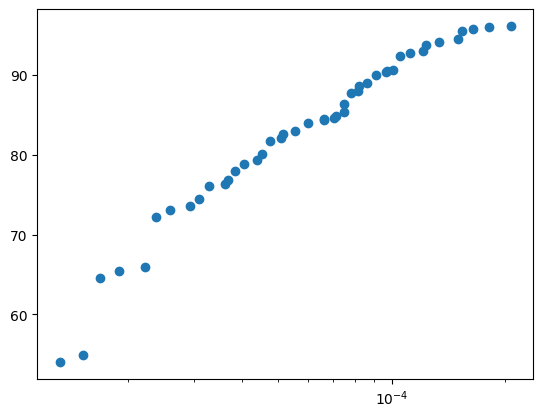

In [40]:
area = ota2_df["area"]
psrr = ota2_df["gain"]

plt.scatter(area, psrr)
plt.xscale("log")

### Simulation

In [41]:
W_diff_pf = (ota2_df[Symbol("W_diff")].values*1e6)
L_diff_pf = (ota2_df[Symbol("L_diff")].values*1e6)

W_al_pf = (ota2_df[Symbol("W_al")].values*1e6)
L_al_pf = (ota2_df[Symbol("L_al")].values*1e6)

W_s2_pf = (ota2_df[Symbol("W_2stage")].values*1e6)
L_s2_pf = (ota2_df[Symbol("L_2stage")].values*1e6)

In [42]:
mult_diff = []
for idx, i in enumerate(W_diff_pf):
    if i>100:
        mult_diff.append(10)
        W_diff_pf[idx] = W_diff_pf[idx]/10
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
        W_al_pf[idx] = W_al_pf[idx]/10
    else:
        mult_al.append(1)

mult_s2 = []
for idx, i in enumerate(W_s2_pf):
    if i>100:
        mult_s2.append(10)
        W_s2_pf[idx] = W_s2_pf[idx]/10
    else:
        mult_s2.append(1)

In [43]:
values = {
    "XM1": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM4": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM5": [
        W_s2_pf,
        L_s2_pf,
        mult_s2,
        "pfet",
    ],
}

simulation_results = spice_sim("stage2_OTA_tb_sim", values)

[array([ 5.51042263,  7.15566425,  5.51042263,  7.15566425, 10.51946155,
        5.51042263,  7.15566425, 10.51946155,  5.51042263,  7.15566425,
       10.51946155, 10.33459047,  5.51042263,  7.15566425, 10.51946155,
        5.51042263,  7.15566425, 10.51946155, 10.33459047, 14.45157642,
       17.37721742, 23.58095399, 10.33459047, 14.45157642, 17.37721742,
        7.15566425, 10.51946155,  7.15566425, 10.51946155, 10.33459047,
       14.45157642, 17.37721742, 23.58095399, 10.33459047, 14.45157642,
       17.37721742, 23.58095399, 33.33841294, 31.75505917, 42.35671844,
       58.70327785, 31.75505917, 42.35671844, 58.70327785, 85.04026819]), array([0.4, 0.8, 0.4, 0.8, 0.8, 0.4, 0.8, 0.8, 0.4, 0.8, 0.8, 1.6, 0.4,
       0.8, 0.8, 0.4, 0.8, 0.8, 1.6, 1.6, 3.2, 3.2, 1.6, 1.6, 3.2, 0.8,
       0.8, 0.8, 0.8, 1.6, 1.6, 3.2, 3.2, 1.6, 1.6, 3.2, 3.2, 3.2, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [44]:
error = []
for idx, _ in enumerate(W_diff_pf):
    error.append(simulation_results[idx].iloc[0,1] - 20*np.log10(ota2_df["psrr_2stage"].values[idx]))

In [45]:
ota2_df["error"] = error

### Results

In [46]:
ota2_df

,Ra_1stage,gma_1stage,Ca_1stage,gm_stage2,Ro_stage2,psrr_2stage,rout_2stage,gm_2stage,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,area,gain,error
0,139196.976308,0.000309,1.000000e-17,0.000090,1.301028e+05,503.149328,1.301028e+05,0.003867,0.000006,4.000000e-07,0.000005,8.000000e-07,0.000001,4.000000e-07,0.000013,54.033938,-0.418805
1,178771.042979,0.000266,1.730196e-17,0.000090,1.301028e+05,556.010280,1.301028e+05,0.004274,0.000007,8.000000e-07,0.000005,8.000000e-07,0.000001,4.000000e-07,0.000015,54.901656,-0.682816
22,139196.976308,0.000309,1.000000e-17,0.000118,3.303730e+05,1679.734510,3.303730e+05,0.005084,0.000006,4.000000e-07,0.000005,8.000000e-07,0.000005,8.000000e-07,0.000017,64.504813,-0.499266
23,178771.042979,0.000266,1.730196e-17,0.000118,3.303730e+05,1856.207696,3.303730e+05,0.005619,0.000007,8.000000e-07,0.000005,8.000000e-07,0.000005,8.000000e-07,0.000019,65.372531,-0.763277
24,167746.221223,0.000301,2.993577e-17,0.000118,3.303730e+05,1973.299863,3.303730e+05,0.005973,0.000011,8.000000e-07,0.000005,8.000000e-07,0.000005,8.000000e-07,0.000022,65.903862,-0.754524
44,139196.976308,0.000309,1.000000e-17,0.000124,7.652536e+05,4091.528649,7.652536e+05,0.005347,0.000006,4.000000e-07,0.000005,8.000000e-07,0.000011,1.600000e-06,0.000024,72.237712,1.961802
45,178771.042979,0.000266,1.730196e-17,0.000124,7.652536e+05,4521.385327,7.652536e+05,0.005908,0.000007,8.000000e-07,0.000005,8.000000e-07,0.000011,1.600000e-06,0.000026,73.105430,1.697790
46,167746.221223,0.000301,2.993577e-17,0.000124,7.652536e+05,4806.600612,7.652536e+05,0.006281,0.000011,8.000000e-07,0.000005,8.000000e-07,0.000011,1.600000e-06,0.000029,73.636761,1.706544
47,177817.781802,0.000311,5.179475e-17,0.000124,7.652536e+05,5266.299864,7.652536e+05,0.006882,0.000006,4.000000e-07,0.000011,1.600000e-06,0.000011,1.600000e-06,0.000031,74.430112,0.316405
48,248715.320160,0.000268,8.961505e-17,0.000124,7.652536e+05,6336.390634,7.652536e+05,0.008280,0.000007,8.000000e-07,0.000011,1.600000e-06,0.000011,1.600000e-06,0.000033,76.036839,-0.004158


# LDO

### Build

In [53]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al"), Symbol("W_2stage"), Symbol("L_2stage"), Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.1,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al"), Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 1}
                              )
stage2_OTA_macro.area_conditions = [10e-2, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_al"), Symbol("L_al")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

In [54]:
W_diff = (ota2_df[Symbol("W_diff")].values)
L_diff = (ota2_df[Symbol("L_diff")].values)

W_al = (ota2_df[Symbol("W_al")].values)
L_al = (ota2_df[Symbol("L_al")].values)

W_2stage = (ota2_df[Symbol("W_2stage")].values)
L_2stage = (ota2_df[Symbol("L_2stage")].values)

gm_2sOTA_macro = ota2_df["gm_2stage"].values
Ro_2sOTA_macro = ota2_df["rout_2stage"].values

In [55]:
final_2sOTA = Primitive(parameters={Symbol("Ra"): Ro_2sOTA_macro,
                                    Symbol("gma"): gm_2sOTA_macro,
                                    Symbol('Ca'): np.logspace(-17, -12, 45)})
final_2sOTA.outputs = {Symbol("W_diff"): W_diff,
                       Symbol("L_diff"): L_diff,
                       Symbol("W_al"): W_al,
                       Symbol("L_al"): L_al,
                       Symbol("W_pt"): W_2stage,
                       Symbol("L_pt"): L_2stage}

In [56]:
LDO_macro.primitives=[final_2sOTA, pt]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=1
LDO_macro.specifications=[psrr_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

In [57]:
ldo_results, ldo_axes, ldo_primouts, ldo_df = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
{<sstadex.models.primitives.Primitive object at 0x7f7223815e70>: {Ra: array([ 130102.84855968,  130102.84855968,  330373.04166112,
        330373.04166112,  330373.04166112,  765253.55455753,
        765253.55455753,  765253.55455753,  765253.55455753,
        765253.55455753,  765253.55455753,  765253.55455753,
       1492358.9326592 , 1492358.9326592 , 1492358.9326592 ,
       1492358.9326592 , 1492358.9326592 , 1492358.9326592 ,
       1492358.9326592 , 1492358.9326592 , 1492358.9326592 ,
       1492358.9326592 , 1492358.9326592 , 1492358.9326592 ,
       1492358.9326592 , 2919277.27767222, 2919277.27767222,
       2919277.27767222, 2919277.27767222, 2919277.27767222,
       2919277.27767222, 2919277.27767222, 2919277.27767222,
       2919277.27767222, 2919277.27767222, 2919277.27767222,
 

In [59]:
ldo_df = ldo_df[ldo_df[Symbol("W_pt")]<13e-3]

In [60]:
ldo_df["gain"] = 20*np.log10(ldo_df["psrr_LDO"])

/tmp/ipykernel_33000/2440209048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldo_df["gain"] = 20*np.log10(ldo_df["psrr_LDO"])


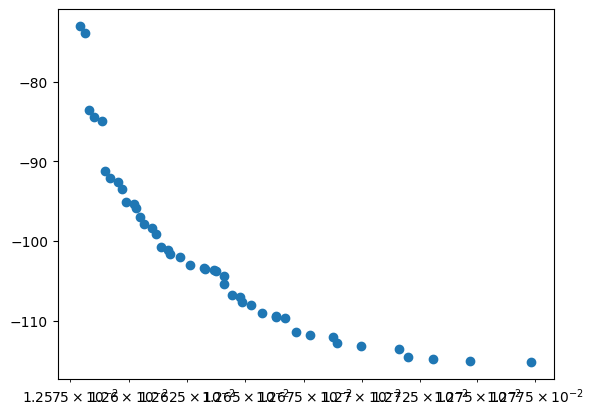

In [61]:
area = ldo_df["area"]
psrr = ldo_df["gain"]

plt.scatter(area, psrr)
plt.xscale("log")

### Simulation

In [62]:
W_diff_pf = (ldo_df[Symbol("W_diff")].values*1e6)
L_diff_pf = (ldo_df[Symbol("L_diff")].values*1e6)

W_al_pf = (ldo_df[Symbol("W_al")].values*1e6)
L_al_pf = (ldo_df[Symbol("L_al")].values*1e6)

W_s2_pf = (ldo_df[Symbol("W_2stage")].values*1e6)
L_s2_pf = (ldo_df[Symbol("L_2stage")].values*1e6)

W_pt = (ldo_df[Symbol("W_pt")].values*1e6)
L_pt = (ldo_df[Symbol("L_pt")].values*1e6)

In [63]:
mult_diff = []
for idx, i in enumerate(W_diff_pf):
    if i>100:
        mult_diff.append(10)
        W_diff_pf[idx] = W_diff_pf[idx]/10
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
        W_al_pf[idx] = W_al_pf[idx]/10
    else:
        mult_al.append(1)

mult_s2 = []
for idx, i in enumerate(W_s2_pf):
    if i>100:
        mult_s2.append(10)
        W_s2_pf[idx] = W_s2_pf[idx]/10
    else:
        mult_s2.append(1)

mult_pt = []
for idx, i in enumerate(W_pt):
    if i>10000:
        mult_pt.append(1000)
        W_pt[idx] = W_pt[idx]/1000
    else:
        mult_pt.append(1)

In [64]:
values = {
    "XM1": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM4": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM5": [
        W_s2_pf,
        L_s2_pf,
        mult_s2,
        "pfet",
    ],
    "XM6": [
        W_pt,
        L_pt,
        mult_pt,
        "pfet",
    ],
}

simulation_results = spice_sim("ldo_sim", values)

[array([ 5.51042263,  7.15566425,  5.51042263,  7.15566425, 10.51946155,
        5.51042263,  7.15566425, 10.51946155,  5.51042263,  7.15566425,
       10.51946155, 10.33459047,  5.51042263,  7.15566425, 10.51946155,
        5.51042263,  7.15566425, 10.51946155, 10.33459047, 14.45157642,
       17.37721742, 23.58095399, 10.33459047, 14.45157642, 17.37721742,
        7.15566425, 10.51946155,  7.15566425, 10.51946155, 10.33459047,
       14.45157642, 17.37721742, 23.58095399, 10.33459047, 14.45157642,
       17.37721742, 23.58095399, 33.33841294, 31.75505917, 42.35671844,
       58.70327785, 31.75505917, 42.35671844, 58.70327785, 85.04026819]), array([0.4, 0.8, 0.4, 0.8, 0.8, 0.4, 0.8, 0.8, 0.4, 0.8, 0.8, 1.6, 0.4,
       0.8, 0.8, 0.4, 0.8, 0.8, 1.6, 1.6, 3.2, 3.2, 1.6, 1.6, 3.2, 0.8,
       0.8, 0.8, 0.8, 1.6, 1.6, 3.2, 3.2, 1.6, 1.6, 3.2, 3.2, 3.2, 6.4,
       6.4, 6.4, 6.4, 6.4, 6.4, 6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [67]:
error = []
for idx, _ in enumerate(W_diff_pf):
    error.append(simulation_results[idx].iloc[0,1] - 20*np.log10(ldo_df["psrr_LDO"].values[idx]))
ldo_df["error"]=error

/tmp/ipykernel_33000/587517086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldo_df["error"]=error


### Results

In [68]:
ldo_df

,Ra,gma,Ca,gm_pt,Ro_pt,psrr_LDO,W_diff,L_diff,W_al,L_al,W_2stage,L_2stage,W_pt,L_pt,area,gain,error
0,1.301028e+05,0.003867,1.000000e-17,0.56669,20.988958,0.000223,0.000006,4.000000e-07,0.000005,8.000000e-07,0.000001,4.000000e-07,0.012566,4.000000e-07,0.012579,-73.047209,0.989309
1,1.301028e+05,0.004274,1.299081e-17,0.56669,20.988958,0.000202,0.000007,8.000000e-07,0.000005,8.000000e-07,0.000001,4.000000e-07,0.012566,4.000000e-07,0.012581,-73.914422,0.881422
2,3.303730e+05,0.005084,1.687612e-17,0.56669,20.988958,0.000067,0.000006,4.000000e-07,0.000005,8.000000e-07,0.000005,8.000000e-07,0.012566,4.000000e-07,0.012583,-83.514359,0.187883
3,3.303730e+05,0.005619,2.192346e-17,0.56669,20.988958,0.000060,0.000007,8.000000e-07,0.000005,8.000000e-07,0.000005,8.000000e-07,0.012566,4.000000e-07,0.012585,-84.381926,0.618984
4,3.303730e+05,0.005973,2.848036e-17,0.56669,20.988958,0.000057,0.000011,8.000000e-07,0.000005,8.000000e-07,0.000005,8.000000e-07,0.012566,4.000000e-07,0.012588,-84.913171,0.620516
5,7.652536e+05,0.005347,3.699830e-17,0.56669,20.988958,0.000027,0.000006,4.000000e-07,0.000005,8.000000e-07,0.000011,1.600000e-06,0.012566,4.000000e-07,0.012590,-91.246319,-33.116375
6,7.652536e+05,0.005908,4.806381e-17,0.56669,20.988958,0.000025,0.000007,8.000000e-07,0.000005,8.000000e-07,0.000011,1.600000e-06,0.012566,4.000000e-07,0.012592,-92.113975,-9.626319
7,7.652536e+05,0.006281,6.243880e-17,0.56669,20.988958,0.000023,0.000011,8.000000e-07,0.000005,8.000000e-07,0.000011,1.600000e-06,0.012566,4.000000e-07,0.012595,-92.645270,-9.077457
8,7.652536e+05,0.006882,8.111308e-17,0.56669,20.988958,0.000021,0.000006,4.000000e-07,0.000011,1.600000e-06,0.000011,1.600000e-06,0.012566,4.000000e-07,0.012597,-93.438573,-0.310949
9,7.652536e+05,0.008280,1.053725e-16,0.56669,20.988958,0.000018,0.000007,8.000000e-07,0.000011,1.600000e-06,0.000011,1.600000e-06,0.012566,4.000000e-07,0.012599,-95.045214,0.003910


In [79]:
ldo_df.iloc[5]

Ra          7.652536e+05
gma         5.346631e-03
Ca          3.699830e-17
gm_pt       5.666899e-01
Ro_pt       2.098896e+01
psrr_LDO    2.739580e-05
W_diff      5.510423e-06
L_diff      4.000000e-07
W_al        4.630982e-06
L_al        8.000000e-07
W_2stage    1.085884e-05
L_2stage    1.600000e-06
W_pt        1.256581e-02
L_pt        4.000000e-07
area        1.259001e-02
gain       -9.124632e+01
error      -3.311638e+01
Name: 5, dtype: float64

In [86]:
1/ldo_df[Symbol("Ro_pt")].values[5]

np.float64(0.04764409887556917)

In [81]:
ota2_df.iloc[5]

Ra_1stage      1.391970e+05
gma_1stage     3.086705e-04
Ca_1stage      1.000000e-17
gm_stage2      1.244387e-04
Ro_stage2      7.652536e+05
psrr_2stage    4.091529e+03
rout_2stage    7.652536e+05
gm_2stage      5.346631e-03
W_diff         5.510423e-06
L_diff         4.000000e-07
W_al           4.630982e-06
L_al           8.000000e-07
W_2stage       1.085884e-05
L_2stage       1.600000e-06
area           2.380024e-05
gain           7.223771e+01
error          1.961802e+00
Name: 44, dtype: float64

In [88]:
1/ota2_df[Symbol("Ro_stage2")].values[5]

np.float64(1.306756426081767e-06)

In [92]:
ota1_df.iloc[0]

Rdif_1         2.193094e+05
gdif_1         3.181359e-04
Cgd           -5.195007e-18
Cgs           -9.169970e-15
Raload_1       3.623237e+05
gaload         1.179690e-04
psrr_1stage    4.296599e+01
rout_1stage    1.391970e+05
gm_1stage      3.086705e-04
W_diff         5.510423e-06
L_diff         4.000000e-07
W_aload        4.630982e-06
L_aload        8.000000e-07
area           1.134140e-05
gain           3.266250e+01
error          1.511039e-01
Name: 14, dtype: float64

In [96]:
Rdiff = 1/ota1_df[Symbol("Rdif_1")].values[0]
Rdiff

np.float64(4.559767165869052e-06)

In [97]:
Ral = 1/ota1_df[Symbol("Raload_1")].values[0]
Ral

np.float64(2.7599631014938703e-06)

In [117]:
rout_ota1 = ota1_df[Symbol("Rdif_1")].values[0]*ota1_df[Symbol("Raload_1")].values[0]/(ota1_df[Symbol("Rdif_1")].values[0]+ota1_df[Symbol("Raload_1")].values[0])
rout_ota1

np.float64(136617.05602169267)

In [109]:
gain_ota1 = rout_ota1*ota1_df[Symbol("gdif_1")].values[0]
gain_ota1

np.float64(43.46279195057977)

In [116]:
gain_ota2 = gain_ota1*ota2_df[Symbol("gm_stage2")].values[0]
gain_ota2

np.float64(0.0039120360374846645)